In [1]:
import numpy as np
import pandas as pd
from numpy import percentile
from sklearn import preprocessing
import matplotlib.pyplot as plt
import matplotlib.font_manager
import seaborn as sns
from scipy import stats
from pandas.api.types import CategoricalDtype

# Import models
from pyod.models.iforest import IForest
from pyod.models.lof import LOF
from pyod.models.ocsvm import OCSVM

In [2]:
# Read data and filter necessary columns
dt = pd.read_csv("filtered.csv")
dt = dt.iloc[:,[10, 2, 3, 19]]
dt.sort_values(["session_user_id", "log_dtimes"], ascending = (True, True))
dt.head(n = 10)

,session_user_id,log_dtimes,log_desc,is_anomaly
0,aaron.dwyer.8569@mailinator.com,2021-06-24 15:15:15.490196,Otp send sucessfully,True
1,aaron.dwyer.8569@mailinator.com,2021-06-24 15:15:16.66885,User sucessfully logged-in,True
2,aaron.dwyer.8569@mailinator.com,2021-06-24 15:15:17.834327,Pre-Registration data is sucessfully saved in ...,True
3,aaron.dwyer.8569@mailinator.com,2021-06-24 15:15:19.342927,Document uploaded & the respective Pre-Registr...,True
4,aaron.dwyer.8569@mailinator.com,2021-06-24 15:15:20.118901,Document uploaded & the respective Pre-Registr...,True
5,aaron.dwyer.8569@mailinator.com,2021-06-24 15:15:20.890152,Document uploaded & the respective Pre-Registr...,True
6,aaron.dwyer.8569@mailinator.com,2021-06-24 15:15:21.660763,Document uploaded & the respective Pre-Registr...,True
7,aaron.dwyer.8569@mailinator.com,2021-06-24 15:15:22.422653,Document uploaded & the respective Pre-Registr...,True
8,aaron.dwyer.8569@mailinator.com,2021-06-24 15:15:23.326873,Availability retrieved successfully for booking,True
9,aaron.dwyer.8569@mailinator.com,2021-06-24 15:15:24.089925,Appointment booked successfully,True


In [3]:
# Handle data types and encode events
categ_order = ['Otp send sucessfully', 'User sucessfully logged-in', 
               'Pre-Registration data is sucessfully saved in the demographic table',
              'Document uploaded & the respective Pre-Registration data is saved in the document table',
              'Availability retrieved successfully for booking',
              'Appointment booked successfully']
cat_type = CategoricalDtype(categories=categ_order, ordered=True)
dt.log_desc = dt.log_desc.astype(cat_type)
dt.log_desc = dt.log_desc.cat.codes

dt.session_user_id = dt.session_user_id.astype('string')
dt['log_dtimes'] = pd.to_datetime(dt['log_dtimes'])

dt.head(n = 10)

,session_user_id,log_dtimes,log_desc,is_anomaly
0,aaron.dwyer.8569@mailinator.com,2021-06-24 15:15:15.490196,0,True
1,aaron.dwyer.8569@mailinator.com,2021-06-24 15:15:16.668850,1,True
2,aaron.dwyer.8569@mailinator.com,2021-06-24 15:15:17.834327,2,True
3,aaron.dwyer.8569@mailinator.com,2021-06-24 15:15:19.342927,3,True
4,aaron.dwyer.8569@mailinator.com,2021-06-24 15:15:20.118901,3,True
5,aaron.dwyer.8569@mailinator.com,2021-06-24 15:15:20.890152,3,True
6,aaron.dwyer.8569@mailinator.com,2021-06-24 15:15:21.660763,3,True
7,aaron.dwyer.8569@mailinator.com,2021-06-24 15:15:22.422653,3,True
8,aaron.dwyer.8569@mailinator.com,2021-06-24 15:15:23.326873,4,True
9,aaron.dwyer.8569@mailinator.com,2021-06-24 15:15:24.089925,5,True


In [4]:
# Retain only the first instance of document upload event
dt['flag'] = dt.groupby('session_user_id')['log_desc'].diff().fillna(1)
dt = dt[dt.flag == 1]
dt = dt.drop(['flag'], 1)
dt['delta'] = dt.groupby('session_user_id')['log_dtimes'].diff()
dt.delta = dt.delta.dt.total_seconds().fillna(0.0)
dt.head(n = 10)

,session_user_id,log_dtimes,log_desc,is_anomaly,delta
0,aaron.dwyer.8569@mailinator.com,2021-06-24 15:15:15.490196,0,True,0.000000
1,aaron.dwyer.8569@mailinator.com,2021-06-24 15:15:16.668850,1,True,1.178654
2,aaron.dwyer.8569@mailinator.com,2021-06-24 15:15:17.834327,2,True,1.165477
3,aaron.dwyer.8569@mailinator.com,2021-06-24 15:15:19.342927,3,True,1.508600
8,aaron.dwyer.8569@mailinator.com,2021-06-24 15:15:23.326873,4,True,3.983946
9,aaron.dwyer.8569@mailinator.com,2021-06-24 15:15:24.089925,5,True,0.763052
10,abel.hewitt.2704@mailinator.com,2021-06-24 14:27:16.527601,0,False,0.000000
11,abel.hewitt.2704@mailinator.com,2021-06-24 14:27:18.291326,1,False,1.763725
12,abel.hewitt.2704@mailinator.com,2021-06-24 14:27:20.424622,2,False,2.133296
13,abel.hewitt.2704@mailinator.com,2021-06-24 14:27:22.127774,3,False,1.703152


In [5]:
# Derive inter-event times and scale features
dt_cast = dt.pivot_table(index=["session_user_id", "is_anomaly"], 
                    columns='log_desc', 
                    values='delta').reset_index()
dt_cast.columns = ['id', 'is_anomaly', 'delta_0', 'delta_1', 'delta_2', 'delta_3', 'delta_4', 'delta_5']

anomaly_labels = dt_cast.is_anomaly
dt_cast = dt_cast.drop(['id','is_anomaly', 'delta_0'], 1)
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(dt_cast.values)
df_scaled = pd.DataFrame(scaled_features, index=dt_cast.index, columns=dt_cast.columns)
df_scaled['is_anomaly'] = anomaly_labels
df_scaled.head(n = 10)

,delta_1,delta_2,delta_3,delta_4,delta_5,is_anomaly
0,0.062279,0.049916,0.152446,0.027995,0.177277,True
1,0.176277,0.218639,0.197812,0.188343,0.286074,False
2,0.213526,0.103768,0.239818,0.134056,0.624017,False
3,0.034473,0.053715,0.061579,0.024217,0.264138,True
4,0.148815,0.069608,0.477632,0.385523,0.186308,False
5,0.431700,0.291468,0.347747,0.354646,0.205723,False
6,0.086819,0.014453,0.016612,0.240526,0.433495,True
7,0.207693,0.131052,0.166416,0.462838,0.277571,False
8,0.209963,0.232873,0.624843,0.438071,0.380762,False
9,0.062633,0.031949,0.069686,0.017354,0.567107,True


In [6]:
# Prepare train data with ony normal events and test data with all events
train_data = df_scaled[df_scaled.is_anomaly == False]
train_data = train_data.drop(['is_anomaly'], 1)
test_data = df_scaled.drop(['is_anomaly'], 1)
train_data.head()

,delta_1,delta_2,delta_3,delta_4,delta_5
1,0.176277,0.218639,0.197812,0.188343,0.286074
2,0.213526,0.103768,0.239818,0.134056,0.624017
4,0.148815,0.069608,0.477632,0.385523,0.186308
5,0.431700,0.291468,0.347747,0.354646,0.205723
7,0.207693,0.131052,0.166416,0.462838,0.277571


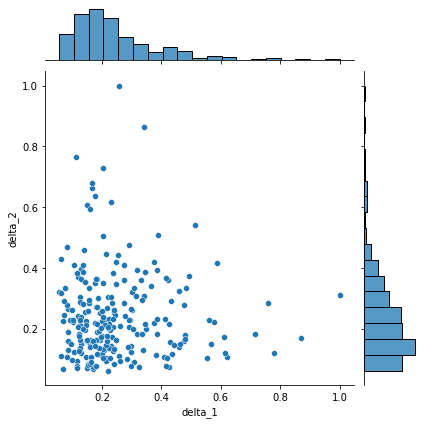

In [7]:
# Scatter plot of first 2 features
sns.jointplot(x=train_data["delta_1"], y=train_data["delta_2"], kind='scatter')

In [8]:
# Fit models and collect results
random_state = np.random.RandomState(42)
results_df = pd.DataFrame(columns=('method', 'outlier_fraction', 'TP', 'FP', 'FN'))

for outliers_fraction in np.arange(0.1, 0.3, 0.02):

    # Define three outlier detection methods to be compared
    methods = {
        'Isolation Forest': IForest(contamination=outliers_fraction,
                                    random_state=random_state),
        'Local Outlier Factor (LOF)':
            LOF(n_neighbors=35, contamination=outliers_fraction),
        'One-class SVM (OCSVM)': OCSVM(contamination=outliers_fraction)
    }

    for i, (clf_name, clf) in enumerate(methods.items()):
        clf.fit(train_data.values)
        # predict raw anomaly score
        scores_pred = clf.decision_function(test_data.values) * -1

        # prediction of a datapoint category outlier or inlier
        y_pred = clf.predict(test_data.values)

        # copy of dataframe
        dfx = df_scaled
        dfx['pred_anomaly'] = y_pred.tolist()
        tpc = len(dfx[(dfx.is_anomaly == 1) & (dfx.pred_anomaly == 1)])
        fpc = len(dfx[(dfx.is_anomaly == 0) & (dfx.pred_anomaly == 1)])
        fnc = len(dfx[(dfx.is_anomaly == 1) & (dfx.pred_anomaly == 0)])
        
        values_to_add = {'method': clf_name, 'outlier_fraction': outliers_fraction, 'TP':tpc, 'FP':fpc, 'FN':fnc}
        row_to_add = pd.Series(values_to_add)

        results_df = results_df.append(row_to_add, ignore_index=True)

In [9]:
# Evaluate models
results_df = results_df.astype({"method": str, "outlier_fraction": float,
                               "TP": int, "FP": int, "FN": int})

results_df['Precision'] = results_df['TP']/(results_df['TP'] + results_df['FP'])
results_df['Recall'] = results_df['TP']/(results_df['TP'] + results_df['FN'])
results_df['F1'] = (2*results_df['Precision']*results_df['Recall'])/(results_df['Precision'] + results_df['Recall'])
results_df['F2'] = (5*results_df['Precision']*results_df['Recall'])/(4*results_df['Precision'] + results_df['Recall'])

results_df.sort_values(["F2"], ascending = False)

,method,outlier_fraction,TP,FP,FN,Precision,Recall,F1,F2
20,One-class SVM (OCSVM),0.22,235,51,0,0.821678,1.000000,0.902111,0.958401
17,One-class SVM (OCSVM),0.20,233,46,2,0.835125,0.991489,0.906615,0.955701
23,One-class SVM (OCSVM),0.24,235,56,0,0.807560,1.000000,0.893536,0.954509
14,One-class SVM (OCSVM),0.18,231,42,4,0.846154,0.982979,0.909449,0.952185
26,One-class SVM (OCSVM),0.26,235,60,0,0.796610,1.000000,0.886792,0.951417
11,One-class SVM (OCSVM),0.16,229,37,6,0.860902,0.974468,0.914172,0.949420
21,Isolation Forest,0.24,233,56,2,0.806228,0.991489,0.889313,0.947925
29,One-class SVM (OCSVM),0.28,235,65,0,0.783333,1.000000,0.878505,0.947581
27,Isolation Forest,0.28,235,65,0,0.783333,1.000000,0.878505,0.947581
18,Isolation Forest,0.22,231,51,4,0.819149,0.982979,0.893617,0.945172
